In [24]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision import models as models
import torchvision
from torch.utils.data import random_split  
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from PIL import Image

import albumentations as A # Image augmentation
from albumentations.pytorch import ToTensorV2 # Image Augmentation

from tqdm.notebook import tqdm

print("import done")

import done


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
print("device:",device)

class_threshold = 0.4

num_epochs = 20
batch_size = 256
lr = 0.0001
img_size = 256  

device: cuda


In [26]:
# 1. Processing the Dataset
resize_img_file = '../input/resized-plant2021/img_sz_256'
# train_img_file="../input/plant-pathology-2021-fgvc8/train_images/"
test_img_dir =  '../input/plant-pathology-2021-fgvc8/test_images/'
train_origin = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

train_origin.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [27]:
#smaller dataset
# train_origin = train_origin.sample(frac=0.4, random_state=42)

In [28]:
# 2. Initialize multi-label labels using one-hot encoding
labels_list = ["healthy", "scab", "rust", "frog_eye_leaf_spot", "powdery_mildew", "complex"]
train_df = train_origin[['image']].copy()
for label in labels_list:
    train_df[label] = 0

for label in labels_list:
    train_df.loc[train_origin['labels'].str.contains(label), label] = 1
train_df.head()

,image,healthy,scab,rust,frog_eye_leaf_spot,powdery_mildew,complex
0,800113bb65efe69e.jpg,1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,0,1,0,1,0,1
2,80070f7fb5e2ccaa.jpg,0,1,0,0,0,0
3,80077517781fb94f.jpg,0,1,0,0,0,0
4,800cbf0ff87721f8.jpg,0,0,0,0,0,1


In [29]:
class PathologyPlantsDataset(Dataset): # Load image
    def __init__(self, image_ids, targets, path, mode, transform=None):
        self.image_ids = image_ids
        self.targets = targets
        self.root_dir = path
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Read image
        image_path = os.path.join(self.root_dir, self.image_ids.iloc[idx])
        image = Image.open(image_path)
        img = np.array(image)
        # Process image
        if self.transform:
            image = self.transform(image=img)['image']
        
        if self.mode == 'test':
            target = None
        else:
            target = torch.tensor(self.targets[idx], dtype=torch.float32) 
        
        return (image, target)

In [31]:
train_transform = A.Compose([
    A.Rotate(
        always_apply=False, 
        p=0.1, 
        limit=(-68, 178), 
        interpolation=1, 
        border_mode=0, 
        value=(0, 0, 0), 
        mask_value=None
    ),
    A.HorizontalFlip(
        p=0.2
    ),
    
#     A.RandomShadow(
#         num_shadows_lower=1, 
#         num_shadows_upper=1, 
#         shadow_dimension=3, 
#         shadow_roi=(0, 0.6, 1, 1), 
#         p=0.4
#     ),
#     A.ShiftScaleRotate(
#         shift_limit=0.05, 
#         scale_limit=0.05, 
#         rotate_limit=15, 
#         p=0.6
#     ),
#     A.RandomFog(
#         fog_coef_lower=0.2, 
#         fog_coef_upper=0.2, 
#         alpha_coef=0.2, 
#         p=0.3
#     ),
#     A.RGBShift(
#         r_shift_limit=15, 
#         g_shift_limit=15, 
#         b_shift_limit=15, 
#         p=0.3
#     ),
    A.RandomBrightnessContrast(
        p=0.3
    ),
    A.GaussNoise(
        var_limit=(50, 70),  
        always_apply=False, 
        p=0.3
    ),
    A.Resize(
        height=img_size,
        width=img_size,
    ),
#     A.CoarseDropout(
#         max_holes=5, 
#         max_height=5, 
#         max_width=5, 
#         min_holes=3, 
#         min_height=5, 
#         min_width=5,
#         always_apply=False, 
#         p=0.2
#     ),
#     A.Normalize(
#         mean=(0.485, 0.456, 0.406), 
#         std=(0.229, 0.224, 0.225)
#     ),
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(
        height=img_size,
        width=img_size,
    ),
#     A.Normalize(
#         mean=(0.485, 0.456, 0.406), 
#         std=(0.229, 0.224, 0.225)
#     ),
    ToTensorV2(),
])


X_train, X_valid, y_train, y_valid = train_test_split(
    train_df['image'], 
    train_df[labels_list].values,  
    test_size=0.2, 
    random_state=42
)
print("Training dataset length：",len(X_train))
print("Testing dataset length：",len(X_valid))

for i in range(2):  # Print the first 2 samples for inspection
    print(f"Image path: {X_train.iloc[i]}, Labels: {y_train[i]}") 

Training dataset length： 14905
Testing dataset length： 3727
Image path: a77c35e0f885c03b.jpg, Labels: [0 0 0 0 0 1]
Image path: 9fbb71e598132988.jpg, Labels: [0 0 1 0 0 0]


In [32]:
train_set = PathologyPlantsDataset(X_train, y_train, path=resize_img_file ,mode='train',transform=train_transform)
val_set = PathologyPlantsDataset(X_valid, y_valid, path=resize_img_file, mode='valid', transform=val_transform)
# train_set = PathologyPlantsDataset(X_train, y_train, path=train_img_file ,mode='train',transform=train_transform)
# val_set = PathologyPlantsDataset(X_valid, y_valid, path=train_img_file, mode='valid', transform=val_transform)

# Hyperparameter settings
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [33]:
def model_resnet():
    # Load pre-trained ResNet50 model
#     model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    model = models.resnet50()
    
    
    # Unfreeze the parameters of all layers (if you need to fine-tune the whole model, you can comment out this code below)
    for param in model.parameters():
        param.requires_grad = False

    # Modify the last layer of the model
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features,512),
        nn.ReLU(),  # ReLU activation function
        nn.BatchNorm1d(512),  # approved standardized layer
        nn.Dropout(0.5),
        nn.Linear(512, 6),  # The final fully connected layer that maps feature dimensions to category numbers
        nn.Sigmoid()  # Sigmoid Activation function for multi-label categorization
    )
    # Załaduj model bezpośrednio z lokalizacji pliku
    model_path='/kaggle/input/resnet50/pytorch/base/1/my_resnet_model.pth'
    model.load_state_dict(torch.load(model_path))
    
    return model


In [34]:
my_resnet = model_resnet().to(device)
# loss_fn = torch.nn.MultiLabelSoftMarginLoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(my_resnet.parameters(), lr=lr)


my_resnet = nn.DataParallel(my_resnet)  #use 2x GPU (it's faster)
# model = model.to(device)
# Zapisanie modelu na dysku
# torch.save(my_resnet.state_dict(), model_path)

In [36]:
total_params = sum(p.numel() for p in my_resnet.parameters())
print("Liczba wszystkich parametrów w modelu: ", total_params)

for name, param in my_resnet.named_parameters():
    print(name, param.size())




print(my_resnet)

Liczba wszystkich parametrów w modelu:  24561222
module.conv1.weight torch.Size([64, 3, 7, 7])
module.bn1.weight torch.Size([64])
module.bn1.bias torch.Size([64])
module.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
module.layer1.0.bn1.weight torch.Size([64])
module.layer1.0.bn1.bias torch.Size([64])
module.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
module.layer1.0.bn2.weight torch.Size([64])
module.layer1.0.bn2.bias torch.Size([64])
module.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
module.layer1.0.bn3.weight torch.Size([256])
module.layer1.0.bn3.bias torch.Size([256])
module.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
module.layer1.0.downsample.1.weight torch.Size([256])
module.layer1.0.downsample.1.bias torch.Size([256])
module.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
module.layer1.1.bn1.weight torch.Size([64])
module.layer1.1.bn1.bias torch.Size([64])
module.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
module.layer1.1.bn2.weight torch.Size([

In [37]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

def to_numpy(tensor):
    return tensor.detach().cpu().numpy()

def get_metrics(y_pred_proba,y_test,threshold=0.5):
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    y1 = y_pred.round().astype(np.float32)
    y2 = y_test.round().astype(np.float32)
    
    
    y_pred = (y_pred_proba > threshold).astype(int)  # Direct conversion to integer  
    f1 = f1_score(y_test, y_pred, average='samples', zero_division=1)
    acc = accuracy_score(y_test,y_pred, normalize=True)

    return acc, f1 

def train_or_valid(dataloader, model, device, loss_fn, optimizer=None, is_train=True):
    torch.cuda.empty_cache()
    loss_val = 0
    accuracy = 0
    f1score = 0
    num_batches = len(dataloader)
    
    if is_train:
        model.train()
    else:
        model.eval()
    
    with torch.set_grad_enabled(is_train):
        stream = tqdm(dataloader)
        for batch, (X, y) in enumerate(stream, start=1):
            X, y = X.to(device).float(), y.to(device)
            
            pred_prob = model(X)
            loss = loss_fn(pred_prob, y)
            
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            loss_val += loss.item()
            acc, f1 = get_metrics(to_numpy(pred_prob), to_numpy(y))
            
            accuracy += acc
            f1score += f1
            
            desc = f'Epoch {epoch:3d}/{num_epochs} - {"train" if is_train else "valid"}_Loss: {loss_val/batch:.4f}, ' + \
                   f'{"train" if is_train else "valid"}_Acc: {accuracy/batch:.4f}, {"train" if is_train else "valid"}_F1: {f1score/batch:.4f}'
            stream.set_description(desc)
    
    return loss_val / num_batches, accuracy / num_batches, f1score / num_batches

def train(dataloader, model, device, loss_fn, optimizer, train_loss, train_acc, train_f1, epoch, num_epochs):
    loss, acc, f1 = train_or_valid(dataloader, model, device, loss_fn, optimizer, is_train=True)
    train_loss.append(loss)
    train_acc.append(acc)
    train_f1.append(f1)

def valid(dataloader, model, device, loss_fn, valid_loss, valid_acc, valid_f1, epoch, num_epochs):
    loss, acc, f1 = train_or_valid(dataloader, model, device, loss_fn, optimizer=None, is_train=False)
    valid_loss.append(loss)
    valid_acc.append(acc)
    valid_f1.append(f1)
    return f1


In [38]:
%%time
# training process

train_loss, train_acc, train_f1 = [], [], []
valid_loss, valid_acc, valid_f1 = [], [], []

best_f1 = 0
for epoch in range(1, num_epochs + 1):
    train(train_loader, my_resnet, device, loss_fn, optimizer, train_loss, train_acc, train_f1, epoch, num_epochs)
    vaild_f1 = valid(valid_loader, my_resnet, device, loss_fn, valid_loss, valid_acc, valid_f1, epoch, num_epochs)
    if vaild_f1 > best_f1:
        torch.save(my_resnet.state_dict(),'Best_model.pth')
        best_f1 = vaild_f1

Epoch   1/20 - train_Loss: 0.8564, train_Acc: 0.0473, train_F1: 0.4148: 100%|██████████| 59/59 [01:37<00:00,  1.65s/it]
Epoch   1/20 - valid_Loss: 0.8416, valid_Acc: 0.0735, valid_F1: 0.5064: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
Epoch   2/20 - train_Loss: 0.8262, train_Acc: 0.0982, train_F1: 0.5161: 100%|██████████| 59/59 [01:22<00:00,  1.41s/it]
Epoch   2/20 - valid_Loss: 0.8112, valid_Acc: 0.1501, valid_F1: 0.5611: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]
Epoch   3/20 - train_Loss: 0.8096, train_Acc: 0.1474, train_F1: 0.5522: 100%|██████████| 59/59 [01:22<00:00,  1.41s/it]
Epoch   3/20 - valid_Loss: 0.7915, valid_Acc: 0.2210, valid_F1: 0.6004: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]
Epoch   4/20 - train_Loss: 0.7950, train_Acc: 0.1938, train_F1: 0.5809: 100%|██████████| 59/59 [01:22<00:00,  1.40s/it]
Epoch   4/20 - valid_Loss: 0.7799, valid_Acc: 0.2545, valid_F1: 0.6220: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]
Epoch   5/20 - train_Loss: 0.7825, train

CPU times: user 27min 18s, sys: 1min 8s, total: 28min 27s
Wall time: 33min 12s


In [39]:
from matplotlib.ticker import MaxNLocator 

def plot_result(train,valid,mode,file_name):
    epochs = range(1, len(train) + 1)
    fig, ax = plt.subplots(figsize=(8, 5)) 
    if mode == 'loss':
        ax.plot(epochs, train, label='Training loss', marker='o')  
        ax.plot(epochs, valid, label='Validation loss', marker='o')  
        ax.legend(frameon=False, fontsize=14)  
        ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))  
        ax.set_title('Loss', fontsize=18)  
        ax.set_xlabel('Epoch', fontsize=14)  
        ax.set_ylabel('Loss', fontsize=14)  
        plt.savefig(file_name + '.png')
#         plt.close(fig)
    elif mode == 'acc':
        ax.plot(epochs, train, label='Training Accuracy', marker='o')  
        ax.plot(epochs, valid, label='Validation accuracy', marker='o')  
        ax.legend(frameon=False, fontsize=14)  
        ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))  
        ax.set_title('Accuracy', fontsize=18)  
        ax.set_xlabel('Epoch', fontsize=14)  
        ax.set_ylabel('Accuracy', fontsize=14)  
        plt.savefig(file_name + '.png')
#         plt.close(fig)
    elif mode =='f1':
        ax.plot(epochs, train, label='Training F1-Score', marker='o')  
        ax.plot(epochs, valid, label='Validation F1-Score', marker='o')  
        ax.legend(frameon=False, fontsize=14)  
        ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))  
        ax.set_title('F1-Score', fontsize=18)  
        ax.set_xlabel('Epoch', fontsize=14)  
        ax.set_ylabel('F1-Score', fontsize=14)  
        plt.savefig(file_name + '.png')
#         plt.close(fig)
                

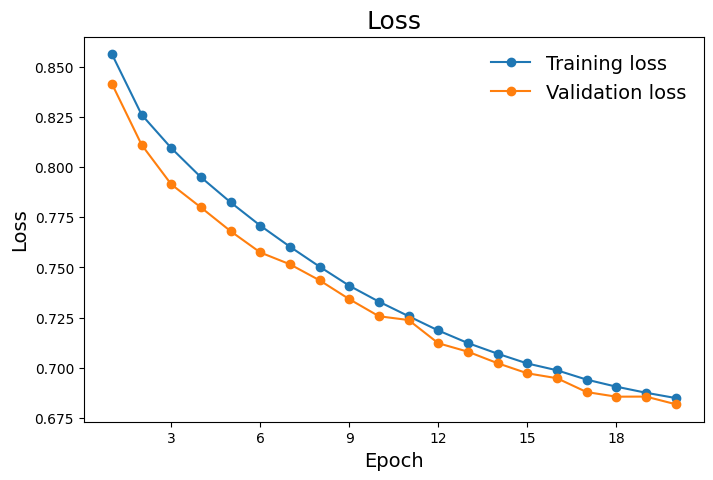

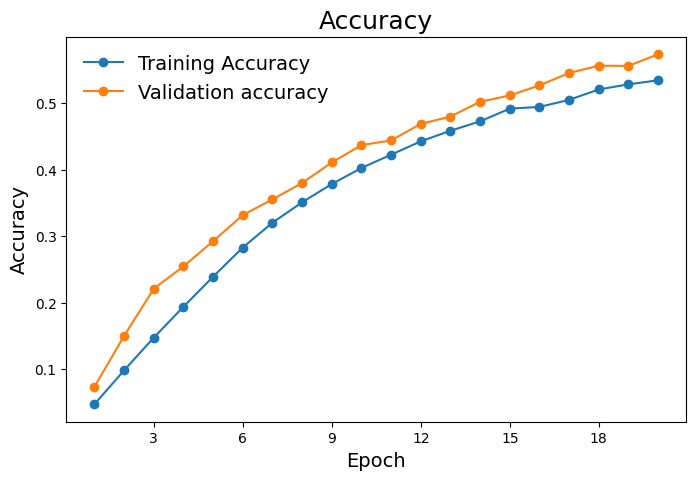

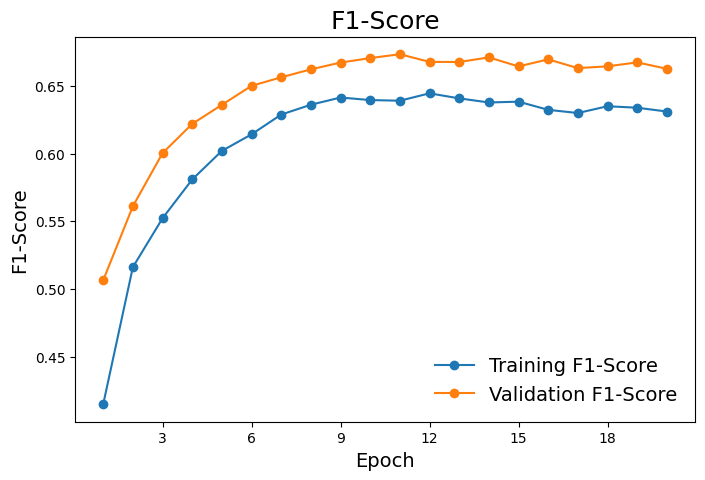

In [40]:
plot_result(train_loss,valid_loss,'loss','res_loss')    
plot_result(train_acc,valid_acc,'acc','res_acc')  
plot_result(train_f1,valid_f1,'f1','res_f1')  

In [16]:



# Define test image directory
test_img_dir = '../input/plant-pathology-2021-fgvc8/test_images'

# Define transformation for test images
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming the model expects input size of 224x224
    transforms.ToTensor(),
])

# Custom dataset class for the test images
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_filenames = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.img_filenames[idx]

# Create DataLoader for the test dataset
test_dataset = TestDataset(test_img_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the best model
model_path = 'Best_model.pth'
my_resnet.load_state_dict(torch.load(model_path))
my_resnet.to(device)

#-----------------------------------------------------------------------

# Function to run inference on the test set and generate predictions
def test(dataloader, model, device):
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        stream = tqdm(dataloader, desc="Testing")
        for X, filenames_batch in stream:
            X = X.to(device)
            pred_proba = model(X)
            y_pred = torch.sigmoid(pred_proba)  # Assuming sigmoid for binary/multilabel classification
            y_pred = (y_pred > 0.5).int()  # Apply threshold

            predictions.extend(y_pred.cpu().numpy())
            filenames.extend(filenames_batch)
    
    return predictions, filenames

# Run the test function with the DataLoader
test_predictions, test_filenames = test(test_loader, my_resnet, device)
# mapped_predictions = map_predictions(test_predictions, 0.5) #ssdsds


# Convert predictions to labels
mapped_predictions = []
for pred in test_predictions:
    classes = [labels_list[i] for i, val in enumerate(pred) if val == 1]
    mapped_pred = ' '.join(classes)
    mapped_predictions.append(mapped_pred)
    
    
# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'image': test_filenames,
    'labels': mapped_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Submission file saved as 'submission.csv'


In [17]:
# Read the submission CSV file
submission_df = pd.read_csv('submission.csv')

# Print the contents of the submission DataFrame
print("Submission DataFrame:")
print(submission_df)


Submission DataFrame:
                  image             labels
0  ad8770db05586b59.jpg  healthy scab rust
1  c7b03e718489f3ca.jpg  healthy scab rust
2  85f8cb619c66b863.jpg  healthy scab rust


In [34]:
# import torch
# from torchvision import transforms
# from PIL import Image

# # Define test image path
# test_img_path = '../input/plant-pathology-2021-fgvc8/train_images/800113bb65efe69e.jpg'

# # Define transformation for the test image
# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Assuming the model expects input size of 224x224
#     transforms.ToTensor(),
# ])

# # Load the test image
# test_image = Image.open(test_img_path).convert('RGB')
# test_image = test_transform(test_image).unsqueeze(0)  # Add batch dimension

# # Load the best model
# model_path = 'Best_model.pth'
# my_resnet.load_state_dict(torch.load(model_path))
# my_resnet.to(device)

# # Put the model in evaluation mode
# my_resnet.eval()

# # Move the test image to the appropriate device
# test_image = test_image.to(device)

# # Perform inference
# with torch.no_grad():
#     pred_proba = my_resnet(test_image)
#     pred_label = torch.sigmoid(pred_proba) > 0.5

# # Convert prediction to label
# labels_list = ["healthy", "scab", "rust", "frog_eye_leaf_spot", "powdery_mildew", "complex"]
# predicted_labels = [labels_list[i] for i, val in enumerate(pred_label.squeeze().tolist()) if val == 1]

# # Print predicted labels
# print("Predicted labels:", predicted_labels)


In [39]:
# test_image_path = '../input/plant-pathology-2021-fgvc8/test_images/'

# test_images = os.listdir(test_image_path)

# os.listdir("/kaggle/working")
# if os.path.exists("/kaggle/working/submission.csv"):
#     os.remove("submission.csv")



# sub = pd.DataFrame(test_images, columns=['image'])
# sub['labels'] = 'frog_eye_leaf_spot'
# sub['labels'] = 'rust'
# print(sub)
# print(len(sub))

                  image labels
0  ad8770db05586b59.jpg   rust
1  c7b03e718489f3ca.jpg   rust
2  85f8cb619c66b863.jpg   rust
3


In [40]:
# sub.to_csv('submission.csv',index=False)